# RoBERTa. Дообучение

In [1]:
# Монтирование google-диска
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# Проверка доступной видеокарты
!nvidia-smi

Sun May 21 09:25:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Установка и импорт библиотек

In [ ]:
!pip install transformers datasets evaluate accelerate

In [4]:
# Импорт библиотек
from datasets import load_dataset
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
from transformers import TrainingArguments, Trainer

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import evaluate
import torch

%matplotlib inline
sns.set(style='whitegrid')

In [5]:
# Проверка доступности GPU
torch.cuda.is_available()

True

## Подготовка датасета

Прежде чем пользоваться самой моделью нам необходимо загрузить датасет, токенизировать его и разбить на обучающую и тестовую выбокри. 

In [ ]:
# Загрузка датасета
dataset = load_dataset("csv", data_files="issue_data_encoded.csv", data_dir="drive/MyDrive/datasets")

In [ ]:
# Добавление токенизатора
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

In [8]:
# Функция токенизации
def tokenize_function(data):
    return tokenizer(data["text"], padding="max_length", truncation=True, max_length=384, return_tensors='pt')

In [9]:
# Токенизация текста
dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/344110 [00:00<?, ? examples/s]

In [10]:
# Разделение выборки на обучающую и тестовую
dataset = dataset['train'].train_test_split(test_size=0.1)

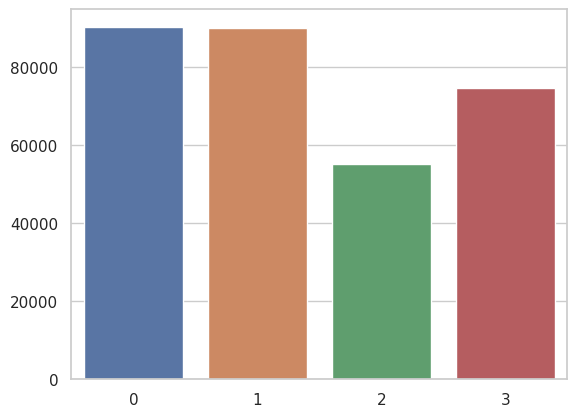

In [11]:
# Распределение меток в обучающей выборке
train_labels, train_count = np.unique(dataset['train']['labels'], return_counts=True)
sns.barplot(x=train_labels, y=train_count)
plt.show()

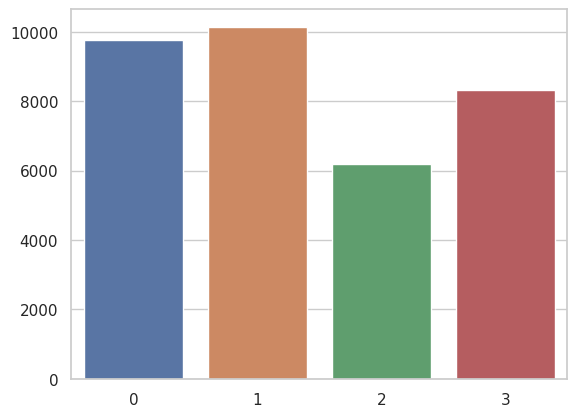

In [12]:
# Распределение меток в тестовой выборке
test_labels, test_count = np.unique(dataset['test']['labels'], return_counts=True)
sns.barplot(x=test_labels, y=test_count)
plt.show()

In [13]:
# Структура датасета
dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'text', 'input_ids', 'attention_mask'],
        num_rows: 309699
    })
    test: Dataset({
        features: ['labels', 'text', 'input_ids', 'attention_mask'],
        num_rows: 34411
    })
})

## Обучение модели

In [14]:
# Создание более мелкой подвыборки
small_train_data = dataset['train'].shuffle(seed=7).select(range(65000))
small_test_data = dataset['test'].shuffle(seed=7).select(range(6500))

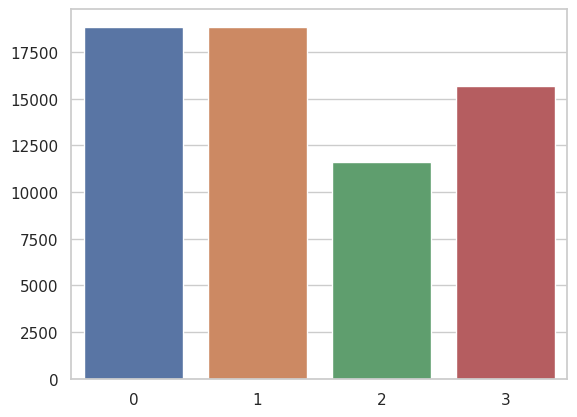

In [15]:
# Распределение меток в малой обучающей выборке
train_labels, train_count = np.unique(small_train_data['labels'], return_counts=True)
sns.barplot(x=train_labels, y=train_count)
plt.show()

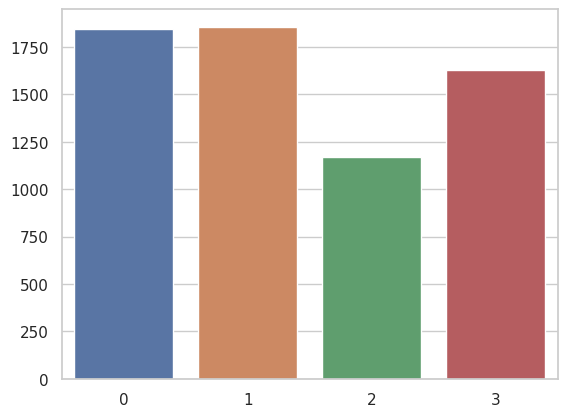

In [16]:
# Распределение меток в малой тестовой выборке
test_labels, test_count = np.unique(small_test_data['labels'], return_counts=True)
sns.barplot(x=test_labels, y=test_count)
plt.show()

In [17]:
id2label = {0 : 'bug', 1 : 'enhancement', 2 : 'documentation', 3 : 'question'}
#label2id = {'bug' : 0, 'feature' : 1, 'documentation' : 2, 'question' : 3}

In [ ]:
# Загрузка модели
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=4,
                                                         id2label=id2label)

In [19]:
# Настройка контролируемых гиперпараметров
training_args = TrainingArguments(output_dir="drive/MyDrive/models/RoBERTa/RoBERTa_model_data",
                                  logging_dir="drive/MyDrive/models/RoBERTa/RoBERTa_model_data/log",
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=16,
                                  learning_rate=1e-5,
                                  num_train_epochs=5,
                                  fp16=True,
                                  optim="adamw_torch_fused",
                                  remove_unused_columns = True,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")

In [ ]:
# Загрузка метрик для валидации
metric_acc = evaluate.load("accuracy")
metric_p = evaluate.load("precision")
metric_r = evaluate.load("recall")
metric_f = evaluate.load("f1")

In [21]:
# Функция для подсчёта метрик
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc =  metric_acc.compute(predictions=predictions, references=labels)
    pres = metric_p.compute(predictions=predictions, references=labels, average='micro')
    rec = metric_r.compute(predictions=predictions, references=labels, average='micro')
    f = metric_f.compute(predictions=predictions, references=labels, average='micro')
    res_metrics = acc | pres | rec | f
    return res_metrics

In [22]:
# Описание тренера
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_data,
    eval_dataset=small_test_data,
    compute_metrics=compute_metrics
)

In [23]:
# Дообучение модели
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.613300,0.597816,0.788154,0.788154,0.788154,0.788154
2,0.537700,0.579793,0.798615,0.798615,0.798615,0.798615
3,0.480600,0.598838,0.796000,0.796000,0.796000,0.796000
4,0.431800,0.634387,0.796154,0.796154,0.796154,0.796154
5,0.377000,0.646857,0.796000,0.796000,0.796000,0.796000


TrainOutput(global_step=20315, training_loss=0.5011195497092665, metrics={'train_runtime': 9853.1223, 'train_samples_per_second': 32.984, 'train_steps_per_second': 2.062, 'total_flos': 6.41344713984e+16, 'train_loss': 0.5011195497092665, 'epoch': 5.0})

In [24]:
# Качество лучшей модели
trainer.evaluate()

{'eval_loss': 0.5797930359840393,
 'eval_accuracy': 0.7986153846153846,
 'eval_precision': 0.7986153846153846,
 'eval_recall': 0.7986153846153846,
 'eval_f1': 0.7986153846153846,
 'eval_runtime': 52.8274,
 'eval_samples_per_second': 123.042,
 'eval_steps_per_second': 7.704,
 'epoch': 5.0}

In [25]:
# Сохранение модели
trainer.save_model("drive/MyDrive/models/RoBERTa/RoBERTa_best_model/")